In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import route_planning.helpers.route_planning_helper as rp_helper
import testing.helpers.testing_helper as test_helper
import config


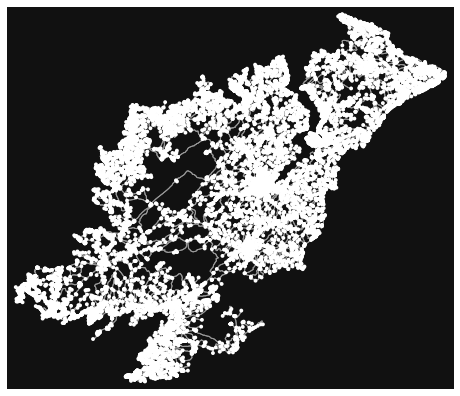

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f366cee9d90>)

In [3]:
# get a graph of Donegal that has all roads, walkways etc
# G_all_donegal = ox.graph_from_place("Donegal, Ireland", network_type="all")
# ox.save_graphml(G_all_donegal, filepath=f"{config.testing_graphml_path}/testing_graph.graphml")


G_all_donegal = ox.load_graphml(filepath=f"{config.testing_graphml_path}/testing_graph.graphml")
# add edge weight attribute
#nx.set_edge_attributes(G_all_donegal, 1.0, "weight")
ox.plot_graph(G_all_donegal)

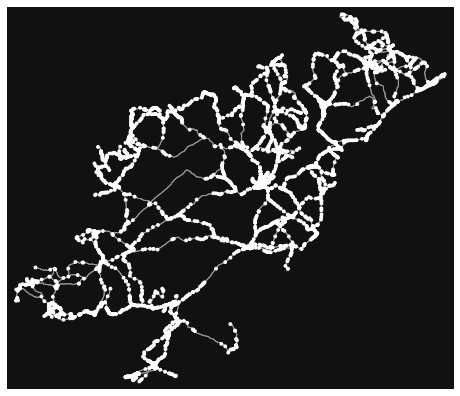

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f367000a910>)

In [4]:
# load the graph with labelled bus stops
G_with_routes = ox.load_graphml(filepath=f"{config.testing_graphml_path}/actual_routes_added.graphml")
# rp_helper.convert_edge_weights_to_floats(G_with_routes)
ox.plot_graph(G_with_routes)

In [5]:
# merge routes data into the testing graph
test_nodes, test_edges = ox.graph_to_gdfs(G_all_donegal)
len(test_nodes)

24742

In [6]:
route_nodes, route_edges = ox.graph_to_gdfs(G_with_routes)
bool_replace = {"True": True, "False": False}
route_nodes["community_route"] = route_nodes["community_route"].map(bool_replace).fillna(False)
# merged_nodes["community_route"] = merged_nodes["community_route"].fillna(False)
route_nodes["actual_stop"] = route_nodes["actual_stop"].map(bool_replace).fillna(False)

len(route_nodes)

3579

In [7]:
actual_stop_nodes = route_nodes[route_nodes["actual_stop"]]["osmid"].tolist()
len(actual_stop_nodes)

122

In [8]:
merged_nodes = gpd.sjoin(test_nodes, route_nodes,
                         how="left", op="intersects")


    #test_nodes.merge(route_nodes, on="osmid", how="left")
len(merged_nodes)

24742

In [9]:
merged_nodes.head()

,y_left,x_left,osmid_left,highway_left,geometry,index_right,y_right,x_right,osmid_right,community,rank,top_n,route_flag,community_route,community_route_order,connection,connection_order,actual_stop,actual_route_order,highway_right
2907242498,54.865236,-7.508191,2907242498,NaN,POINT (-7.50819 54.86524),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
780664835,54.972684,-7.709056,780664835,NaN,POINT (-7.70906 54.97268),7.806648e+08,54.972684,-7.709056,7.806648e+08,10,0.0002789561526694481,0,0,False,-1,None,-1,False,NaN,NaN
2114650125,55.036243,-7.383424,2114650125,NaN,POINT (-7.38342 55.03624),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3778150429,54.852483,-7.525723,3778150429,NaN,POINT (-7.52572 54.85248),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1417674781,55.225775,-7.085802,1417674781,NaN,POINT (-7.08580 55.22577),1.417675e+09,55.225775,-7.085802,1.417675e+09,1,0.00020443990694311745,0,0,False,101,None,99,False,NaN,NaN


In [10]:
# remove duplicate columns introduced in merge, these are all default values
merged_nodes = merged_nodes.loc[:,~merged_nodes.columns.str.endswith("_right")]
merged_nodes.head()

,y_left,x_left,osmid_left,highway_left,geometry,community,rank,top_n,route_flag,community_route,community_route_order,connection,connection_order,actual_stop,actual_route_order
2907242498,54.865236,-7.508191,2907242498,NaN,POINT (-7.50819 54.86524),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
780664835,54.972684,-7.709056,780664835,NaN,POINT (-7.70906 54.97268),10,0.0002789561526694481,0,0,False,-1,None,-1,False,NaN
2114650125,55.036243,-7.383424,2114650125,NaN,POINT (-7.38342 55.03624),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3778150429,54.852483,-7.525723,3778150429,NaN,POINT (-7.52572 54.85248),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1417674781,55.225775,-7.085802,1417674781,NaN,POINT (-7.08580 55.22577),1,0.00020443990694311745,0,0,False,101,None,99,False,NaN


In [11]:
# remove "_left" from remaining column names
merged_nodes.columns = [col.replace("_left", "") for col in merged_nodes.columns]
merged_nodes.head()

,y,x,osmid,highway,geometry,community,rank,top_n,route_flag,community_route,community_route_order,connection,connection_order,actual_stop,actual_route_order
2907242498,54.865236,-7.508191,2907242498,NaN,POINT (-7.50819 54.86524),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
780664835,54.972684,-7.709056,780664835,NaN,POINT (-7.70906 54.97268),10,0.0002789561526694481,0,0,False,-1,None,-1,False,NaN
2114650125,55.036243,-7.383424,2114650125,NaN,POINT (-7.38342 55.03624),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3778150429,54.852483,-7.525723,3778150429,NaN,POINT (-7.52572 54.85248),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1417674781,55.225775,-7.085802,1417674781,NaN,POINT (-7.08580 55.22577),1,0.00020443990694311745,0,0,False,101,None,99,False,NaN


In [12]:
# check that all "actual" stops are present
merged_actual_stop_nodes = merged_nodes[merged_nodes["actual_stop"] == True]["osmid"].tolist()
len(merged_actual_stop_nodes)

119

In [13]:
# find the 2 missing nodes
diff = set(actual_stop_nodes).difference(merged_actual_stop_nodes)
diff

{258453072, 320673554, 2411894191}

In [14]:
merged_nodes.loc[merged_nodes["osmid"].isin(diff)]

,y,x,osmid,highway,geometry,community,rank,top_n,route_flag,community_route,community_route_order,connection,connection_order,actual_stop,actual_route_order
320673554,54.932912,-7.596713,320673554,NaN,POINT (-7.59671 54.93291),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258453072,55.334708,-7.286484,258453072,NaN,POINT (-7.28648 55.33471),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
merged_nodes.loc[(merged_nodes["osmid"] == 320673554), "actual_stop"] = True
merged_nodes.loc[(merged_nodes["osmid"] == 258453072), "actual_stop"] = True
len(merged_nodes[merged_nodes["actual_stop"] == True]["osmid"])

# merged_nodes[merged_nodes["osmid"]]

121

In [16]:
# check that all generated stops were added
connecting_labels = ["a", "b", "c", "d"]
connection_present = merged_nodes["connection"].isin(connecting_labels).value_counts()
connection_present.values[1] + len(merged_nodes[merged_nodes["community_route"] == True])

679

In [17]:
# 8 missing, compare community route nodes first
community_route_nodes = route_nodes[route_nodes["community_route"]]["osmid"].tolist()
len(community_route_nodes)

539

In [18]:
merged_community_route_nodes = merged_nodes[merged_nodes["community_route"] == True]["osmid"].tolist()
len(merged_community_route_nodes)

523

In [19]:
# Find missing nodes
diff = set(community_route_nodes).difference(merged_community_route_nodes)
diff

{258438551,
 258466029,
 320660381,
 320673554,
 821215522,
 821222613,
 821234197,
 1417678805,
 1417678858,
 1435314101,
 1435314108,
 1556355680,
 1641061531,
 2111294750,
 2397804385,
 2907774312}

In [20]:
# update those nodes
for d in diff:
    merged_nodes.loc[(merged_nodes["osmid"] == d), "community_route"] = True
len(merged_nodes[merged_nodes["community_route"] == True]["osmid"])

539

In [22]:
connection_present.values[1]

156

In [23]:
test_edges.head()

,osmid,ref,highway,oneway,length,geometry,name,bridge,lanes,maxspeed,access,width,service,junction,tunnel,area,u,v,key
0,182668958,N14,trunk,False,826.234,"LINESTRING (-7.50819 54.86524, -7.50788 54.864...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2907242498,7802305734,0
1,182668958,N14,trunk,False,735.144,"LINESTRING (-7.50819 54.86524, -7.50841 54.865...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2907242498,7802305709,0
2,"[374424339, 287062886]",NaN,unclassified,False,73.962,"LINESTRING (-7.50819 54.86524, -7.50797 54.865...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2907242498,1514185751,0
3,"[374424339, 374424926]",NaN,unclassified,False,912.414,"LINESTRING (-7.50819 54.86524, -7.50845 54.865...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2907242498,1514179617,0
4,67774207,NaN,tertiary,False,34.944,"LINESTRING (-7.70906 54.97268, -7.70870 54.97292)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,780664835,818377528,0


In [11]:
# add edge weights
# populated_edges = route_edges[route_edges["weight"] > 1]
# len(populated_edges)

1401

In [12]:
# populated_edges.head()

,osmid,ref,highway,oneway,length,geometry,weight,maxspeed,lanes,name,bridge,junction,width,tunnel,access,u,v,key
2,24243010,R239,secondary,False,2188.718,"LINESTRING (-7.40146 55.05867, -7.40079 55.059...",463.0,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2114650363,1411721776,0
5,226720237,R238,secondary,False,297.747,"LINESTRING (-7.43141 55.06528, -7.43107 55.065...",109.0,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,2114650574,2114649685,0
34,129304808,R238,secondary,False,887.556,"LINESTRING (-7.22784 55.09832, -7.22883 55.097...",135.0,100,2,NaN,NaN,NaN,NaN,NaN,NaN,1411715929,1315472999,0
38,"[370868488, 370869445]",R238,secondary,False,438.967,"LINESTRING (-7.45066 55.07660, -7.45045 55.076...",5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2679019572,2114649718,0
45,370868489,R238,secondary,False,231.536,"LINESTRING (-7.46120 55.08284, -7.46112 55.082...",135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2114692414,258430916,0


In [ ]:
# i = 0
# for index, row in populated_edges.iterrows():
#     test_edges.loc[
#         (test_edges["geometry"] == row["geometry"]), "weight"] = row["weight"]
#     i += 1
#     print(i)

24243010
226720237
129304808
[370868488, 370869445]
370868489
[234652016, 234652002, 234651994]
[370868489, 370869445]
131652365
370868489
24243010
42389492
24243010
116758170
24243010
24243010
24243010
24243010
24243010
30727892
234652002
77630071
116758170
116758170
25525896
25525896
30726123
131652365
131652365
370868489
374315811
370868489
[668274666, 24351103]
226720237
42389492
24243010
[129304808, 668274667]
226720261
226720237
24351103
30726123
226720237
[370868488, 370869445]
[370868488, 226720237]
30504607
226720261
[24243008, 303016529, 303016530]
303004298
303004298
303004298
178231317
370878874
370878874
24243008
[231277268, 24242997, 231277270]
[668261546, 517920954]
23848297
[302947250, 302947246]
668261534
[143950018, 339564174, 339564175]
231267773
668261534
668261534
302757359
[201554584, 520021002, 201554570, 520020979]
562301519
302728952
189832516
[243108144, 243108142, 231267773, 23866318]
[143950018, 339564174, 339564175]
[231267769, 231267771, 231267773]
3027354

In [24]:
# recreate test graph with route data included
G = ox.graph_from_gdfs(merged_nodes, test_edges)
len(G.nodes)

24742

In [25]:
ox.save_graphml(G, filepath=f"{config.testing_graphml_path}/merged_routes.graphml")

In [ ]:
ox.plot_graph(G)

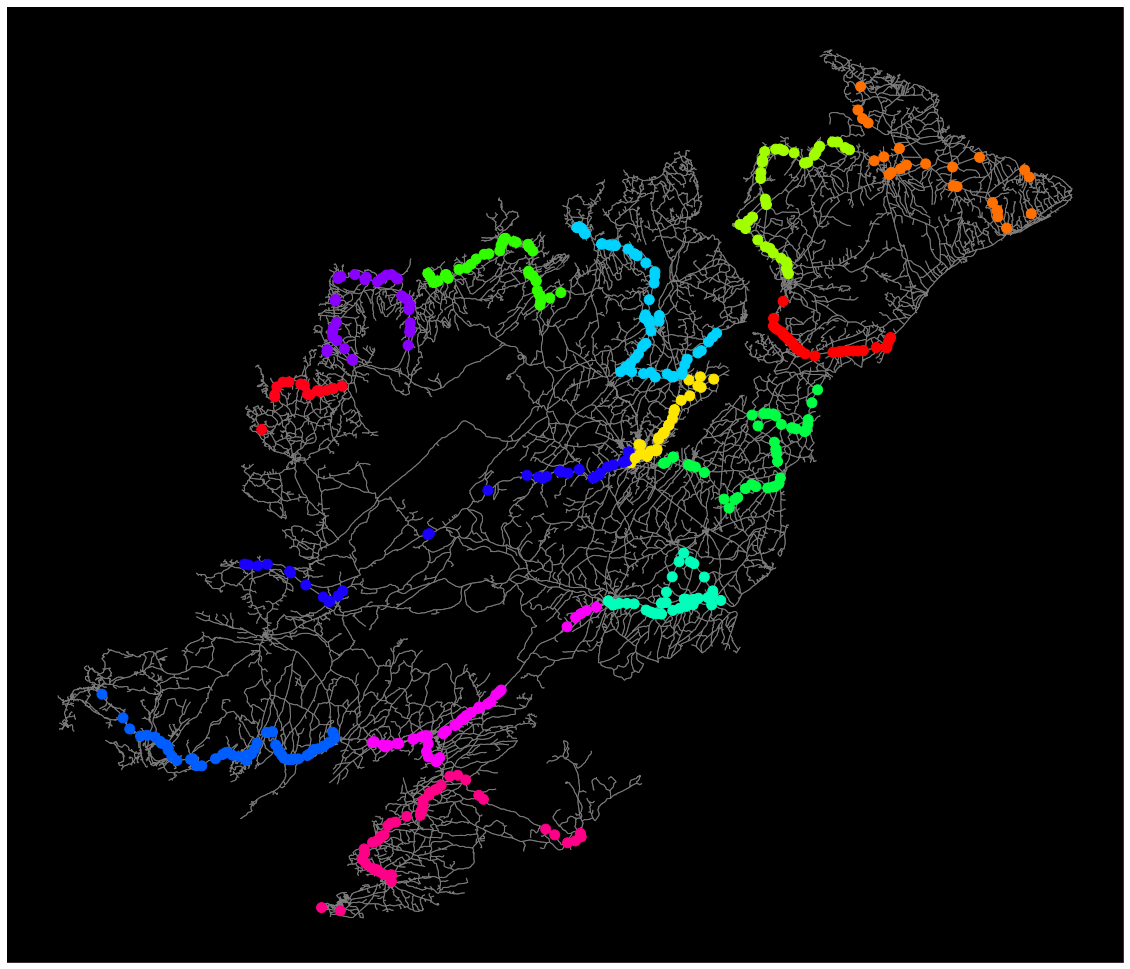

In [26]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

nodes, edges = ox.graph_to_gdfs(G)
nodes = nodes[nodes["community_route"] == True]
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_facecolor("black")

plt.rc("legend", fontsize=25,
       facecolor="black")

edges.plot(
    ax=ax,
    edgecolor="grey",
    linewidth=1,
    facecolor="none",
    zorder=1,
    alpha=0.8
)

nodes.plot(
    ax=ax,
    marker="o",
    markersize=100,
    column="community",
    cmap="hsv",
    zorder=2,
    #legend=legend,
    categorical=True
)

